In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

In [2]:
# Load the dataset
df = pd.read_csv('/Users/new/Desktop/DATA FOR PROJECTS/FOOTBALL_WEB_SCRAPPING/football_data.csv')


In [3]:
# Step 1: Check for missing values
print("Missing values in the dataset:")
print(df.isnull().sum())

Missing values in the dataset:
date           0
home_team      0
home_score     0
away_score     0
away_team      0
final_score    0
dtype: int64


In [4]:
# Step 2: Handle missing values
# Drop rows with missing critical columns (e.g., home_team, away_team, home_score, away_score)
df.dropna(subset=['home_team', 'away_team', 'home_score', 'away_score'], inplace=True)

In [5]:
# Step 3: Handle invalid values
# Ensure scores are non-negative
df = df[(df['home_score'] >= 0) & (df['away_score'] >= 0)]

In [6]:
# Step 4: Remove duplicates
df.drop_duplicates(inplace=True)


In [7]:
# Step 5: Validate data logic
# Ensure home_team and away_team are not the same in a match
df = df[df['home_team'] != df['away_team']]

In [8]:
# Add a 'points' column for home and away teams
df['home_points'] = df.apply(lambda row: 3 if row['home_score'] > row['away_score'] else (1 if row['home_score'] == row['away_score'] else 0), axis=1)
df['away_points'] = df.apply(lambda row: 3 if row['away_score'] > row['home_score'] else (1 if row['away_score'] == row['home_score'] else 0), axis=1)

In [9]:
# Calculate total points for each team so far
home_points = df.groupby('home_team')['home_points'].sum()
away_points = df.groupby('away_team')['away_points'].sum()
total_points = home_points.add(away_points, fill_value=0)

In [10]:
# Calculate goal difference for each team
home_goals = df.groupby('home_team')['home_score'].sum()
away_goals = df.groupby('away_team')['away_score'].sum()
total_goals_scored = home_goals.add(away_goals, fill_value=0)

In [11]:
home_conceded = df.groupby('home_team')['away_score'].sum()
away_conceded = df.groupby('away_team')['home_score'].sum()
total_goals_conceded = home_conceded.add(away_conceded, fill_value=0)

In [12]:
goal_difference = total_goals_scored - total_goals_conceded

In [13]:
# Calculate clean sheets (matches without conceding goals)
home_clean_sheets = df[df['away_score'] == 0].groupby('home_team').size()
away_clean_sheets = df[df['home_score'] == 0].groupby('away_team').size()
total_clean_sheets = home_clean_sheets.add(away_clean_sheets, fill_value=0)

In [14]:

# Combine into a single DataFrame
team_stats = pd.DataFrame({
    'team': total_points.index,
    'points': total_points.values,
    'goals_scored': total_goals_scored.values,
    'goals_conceded': total_goals_conceded.values,
    'goal_difference': goal_difference.values,
    'clean_sheets': total_clean_sheets.values
})

In [15]:
# Feature Engineering
# Calculate matches played
home_matches = df['home_team'].value_counts()
away_matches = df['away_team'].value_counts()
team_stats['matches_played'] = team_stats['team'].map(home_matches.add(away_matches, fill_value=0))


In [16]:
# Calculate average points per match
team_stats['avg_points_per_match'] = team_stats['points'] / team_stats['matches_played']

In [17]:
# Add a 'form' column (average points in the last 5 matches)
df['form'] = df.groupby('home_team')['home_points'].rolling(window=5, min_periods=1).mean().reset_index(level=0, drop=True)
team_stats = team_stats.merge(df.groupby('home_team')['form'].last().reset_index(), how='left', left_on='team', right_on='home_team')


In [18]:
# Step 6: Clean team_stats DataFrame
# Check for missing values in team_stats
print("Missing values in team_stats:")
print(team_stats.isnull().sum())


Missing values in team_stats:
team                    0
points                  0
goals_scored            0
goals_conceded          0
goal_difference         0
clean_sheets            0
matches_played          0
avg_points_per_match    0
home_team               0
form                    0
dtype: int64


In [19]:
# Handle missing values in team_stats
team_stats['form'].fillna(0, inplace=True)  # Fill missing 'form' values with 0
team_stats['matches_played'].fillna(0, inplace=True)  # Fill missing 'matches_played' with 0
team_stats['avg_points_per_match'].fillna(0, inplace=True)  # Fill missing 'avg_points_per_match' with 0

In [20]:
# Ensure no zero or negative matches_played
team_stats['matches_played'] = team_stats['matches_played'].replace(0, 1)  # Replace 0 with 1 to avoid division by zero

In [21]:
# Train-Test Split
# Features and target
X = team_stats[['goals_scored', 'goals_conceded', 'goal_difference', 'clean_sheets', 'avg_points_per_match', 'form']]
y = team_stats['points']

In [22]:

# Impute missing values with the mean of the column
imputer = SimpleImputer(strategy='mean')
X_imputed = imputer.fit_transform(X)

In [23]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X_imputed, y, test_size=0.2, random_state=42)


In [25]:
# Train a Regression Model
model = LinearRegression()
model.fit(X_train, y_train)


LinearRegression()

In [26]:
# Predict
y_pred = model.predict(X_test)

In [27]:
# Evaluate
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')

Mean Squared Error: 0.8016015473702613


In [28]:
# Predict Final Points
team_stats['predicted_points'] = model.predict(X_imputed)

In [29]:
# Scale predicted points to 38 matches
team_stats['predicted_points'] = team_stats['avg_points_per_match'] * 38

In [30]:
# Sort by predicted points
team_stats = team_stats.sort_values(by='predicted_points', ascending=False)

In [31]:
# Output Results
# Top 4 Teams (Champions League Qualification)
top_4 = team_stats[['team', 'predicted_points']].head(4)
print("Top 4 Teams Qualifying for Champions League:")
print(top_4)

Top 4 Teams Qualifying for Champions League:
             team  predicted_points
11      Liverpool         91.724138
0         Arsenal         74.642857
15  Nott'm Forest         69.214286
5         Chelsea         66.500000


In [32]:
# Bottom 3 Teams
bottom_3 = team_stats[['team', 'predicted_points']].tail(3)
print("Bottom 3 Teams:")
print(bottom_3)


Bottom 3 Teams:
           team  predicted_points
9       Ipswich         23.071429
10    Leicester         23.071429
16  Southampton         12.214286


In [33]:
# Team with Most Goal Difference
best_goal_diff = team_stats.loc[team_stats['goal_difference'].idxmax()]
print("Team with Most Goal Difference:")
print(best_goal_diff[['team', 'goal_difference']])

Team with Most Goal Difference:
team               Liverpool
goal_difference           42
Name: 11, dtype: object


In [34]:
# Team with Most Clean Sheets
most_clean_sheets = team_stats.loc[team_stats['clean_sheets'].idxmax()]
print("Team with Most Clean Sheets:")
print(most_clean_sheets[['team', 'clean_sheets']])

Team with Most Clean Sheets:
team            Liverpool
clean_sheets         12.0
Name: 11, dtype: object


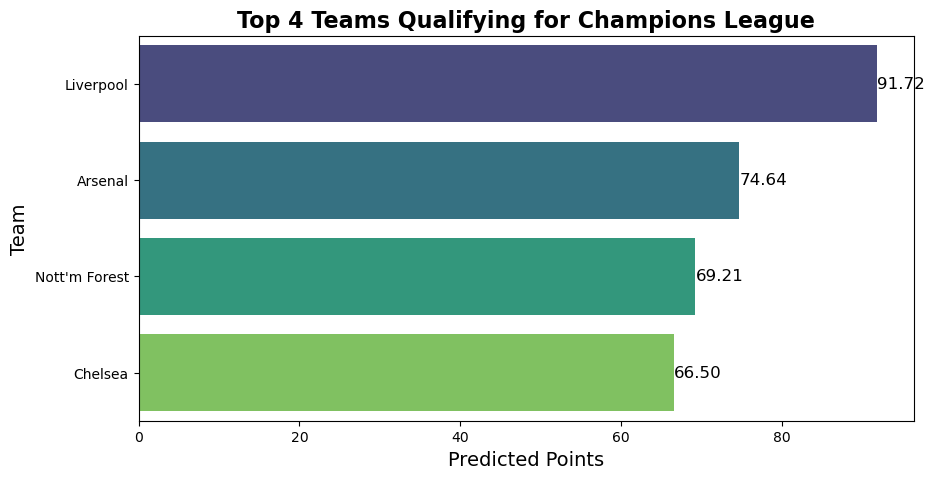

In [35]:
# Visualize Predictions
# Top 4 Teams (Champions League Qualification)
plt.figure(figsize=(10, 5))
sns.barplot(x='predicted_points', y='team', data=top_4, palette='viridis')
plt.title('Top 4 Teams Qualifying for Champions League', fontsize=16, fontweight='bold')
plt.xlabel('Predicted Points', fontsize=14)
plt.ylabel('Team', fontsize=14)
# Add annotations
for index, value in enumerate(top_4['predicted_points']):
    plt.text(value, index, f'{value:.2f}', va='center', fontsize=12, color='black')
plt.show()

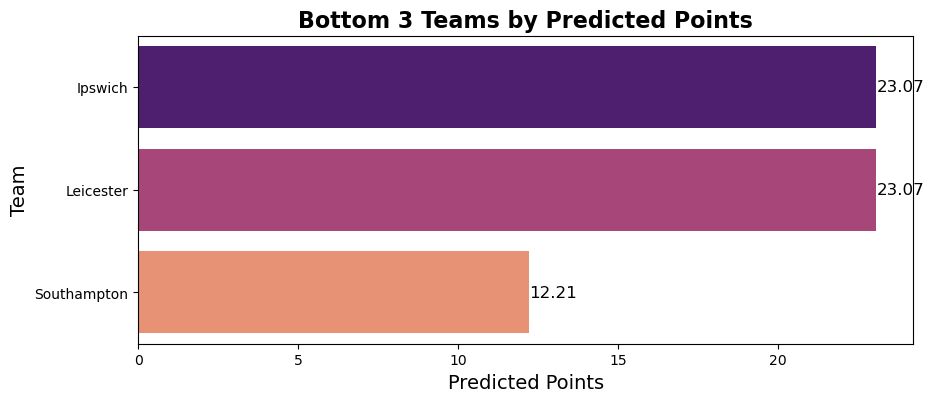

In [36]:
# Bottom 3 Teams
plt.figure(figsize=(10, 4))
sns.barplot(x='predicted_points', y='team', data=bottom_3, palette='magma')
plt.title('Bottom 3 Teams by Predicted Points', fontsize=16, fontweight='bold')
plt.xlabel('Predicted Points', fontsize=14)
plt.ylabel('Team', fontsize=14)
# Add annotations
for index, value in enumerate(bottom_3['predicted_points']):
    plt.text(value, index, f'{value:.2f}', va='center', fontsize=12, color='black')
plt.show()

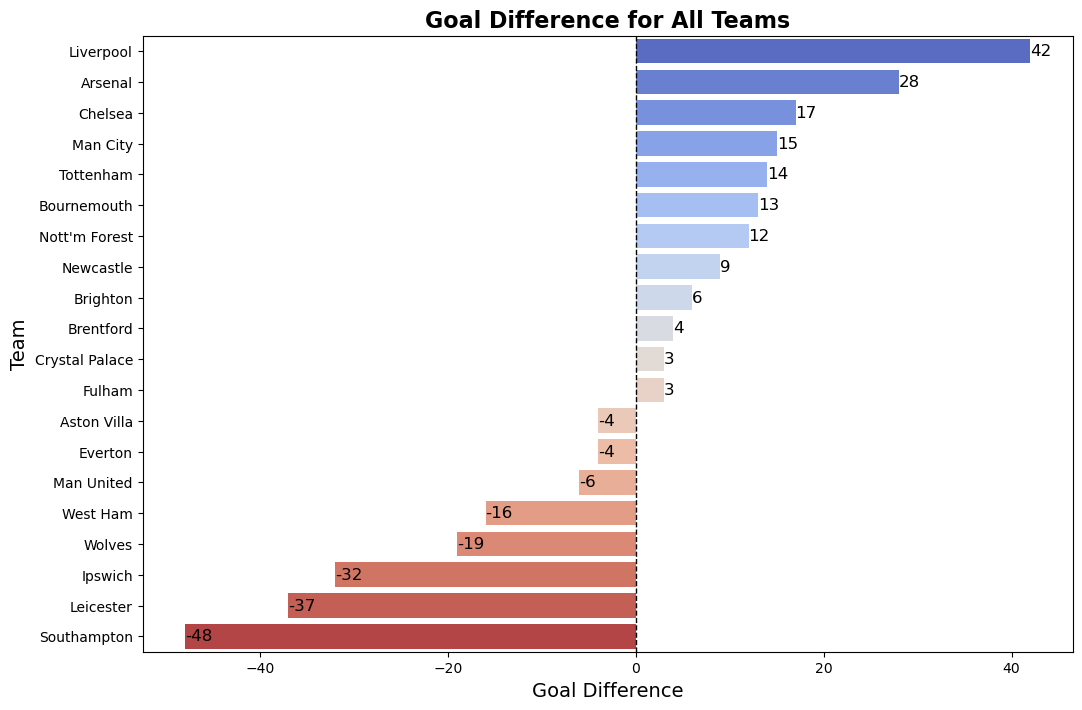

In [37]:
# Goal Difference Distribution for All Teams
plt.figure(figsize=(12, 8))
sns.barplot(x='goal_difference', y='team', data=team_stats.sort_values('goal_difference', ascending=False), palette='coolwarm')
plt.title('Goal Difference for All Teams', fontsize=16, fontweight='bold')
plt.xlabel('Goal Difference', fontsize=14)
plt.ylabel('Team', fontsize=14)
# Add a vertical line at 0 for reference
plt.axvline(0, color='black', linestyle='--', linewidth=1)
# Add annotations
for index, value in enumerate(team_stats.sort_values('goal_difference', ascending=False)['goal_difference']):
    plt.text(value, index, f'{int(value)}', va='center', fontsize=12, color='black')
plt.show()

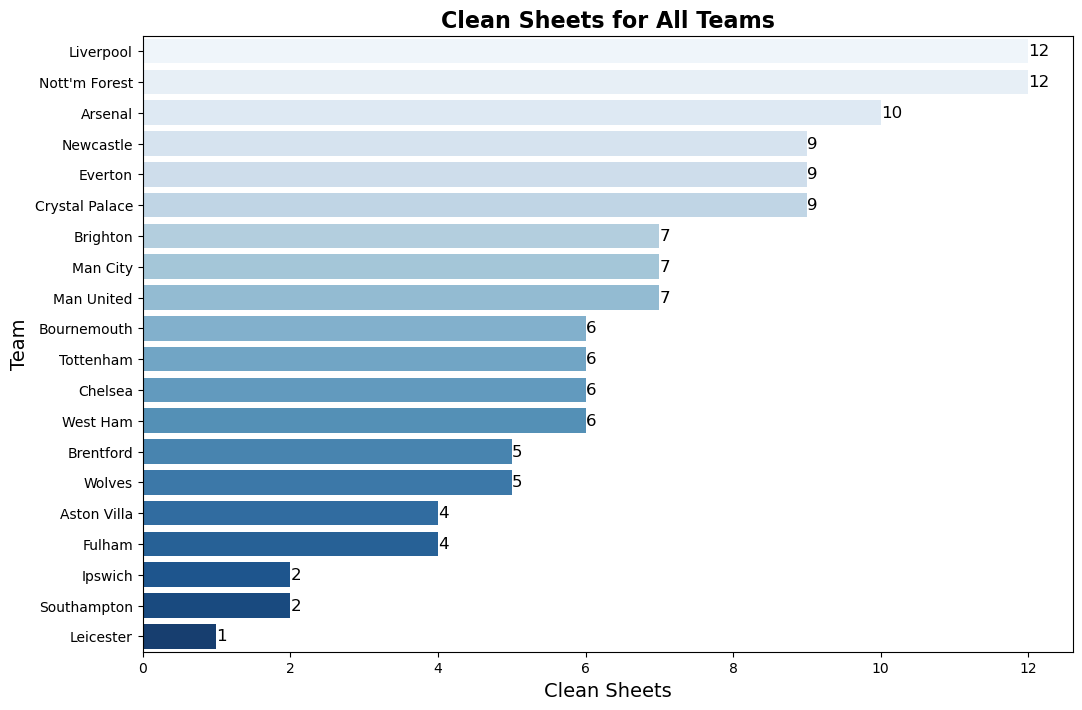

In [38]:
# Clean Sheets Distribution for All Teams
plt.figure(figsize=(12, 8))
sns.barplot(x='clean_sheets', y='team', data=team_stats.sort_values('clean_sheets', ascending=False), palette='Blues')
plt.title('Clean Sheets for All Teams', fontsize=16, fontweight='bold')
plt.xlabel('Clean Sheets', fontsize=14)
plt.ylabel('Team', fontsize=14)
# Add annotations
for index, value in enumerate(team_stats.sort_values('clean_sheets', ascending=False)['clean_sheets']):
    plt.text(value, index, f'{int(value)}', va='center', fontsize=12, color='black')
plt.show()


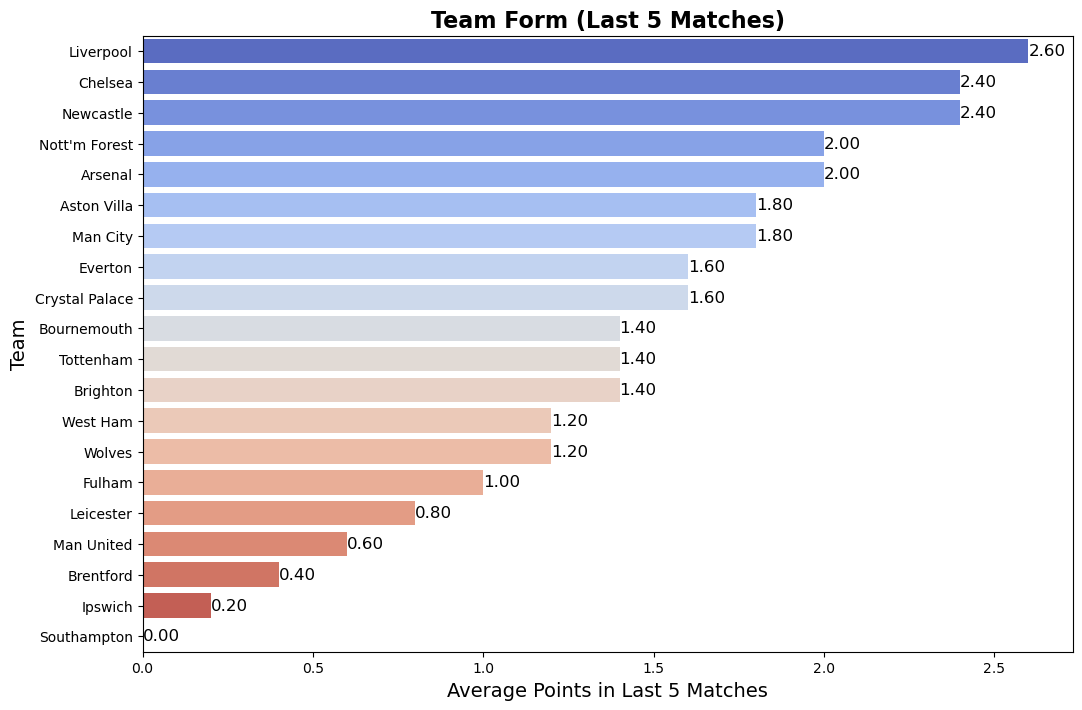

In [39]:
# Form Analysis
plt.figure(figsize=(12, 8))
sns.barplot(x='form', y='team', data=team_stats.sort_values('form', ascending=False), palette='coolwarm')
plt.title('Team Form (Last 5 Matches)', fontsize=16, fontweight='bold')
plt.xlabel('Average Points in Last 5 Matches', fontsize=14)
plt.ylabel('Team', fontsize=14)
# Add annotations
for index, value in enumerate(team_stats.sort_values('form', ascending=False)['form']):
    plt.text(value, index, f'{value:.2f}', va='center', fontsize=12, color='black')
plt.show()

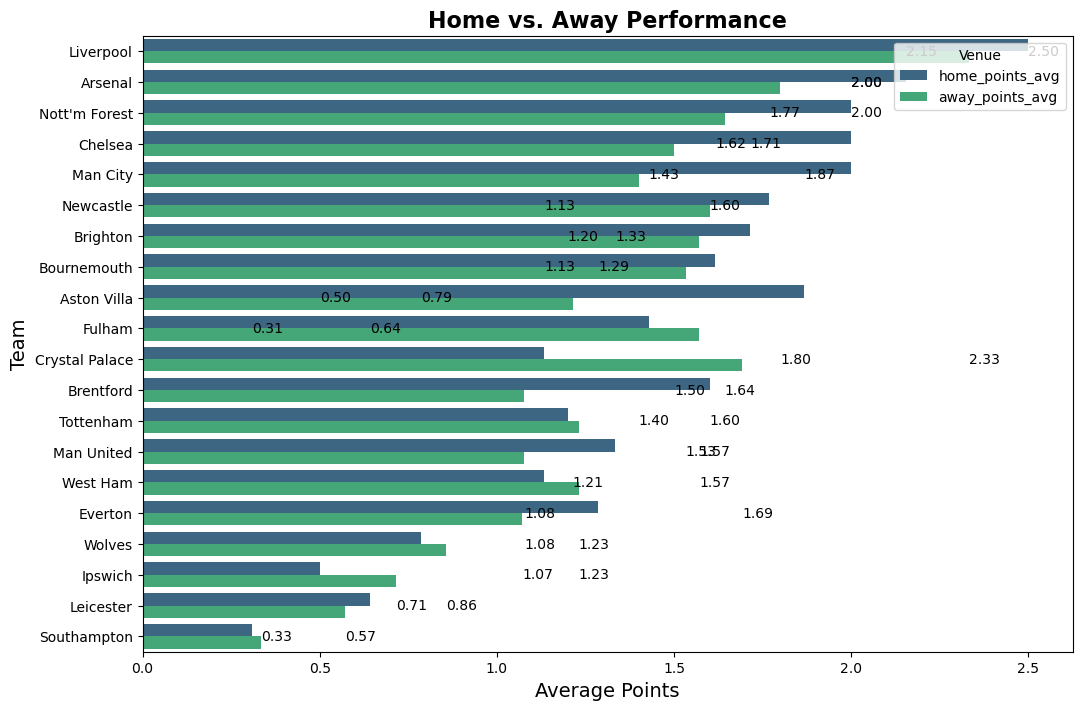

In [40]:
# Home vs. Away Performance
# Calculate average home and away points for each team
home_performance = df.groupby('home_team')['home_points'].mean().reset_index()
away_performance = df.groupby('away_team')['away_points'].mean().reset_index()

# Merge home and away performance data
performance = home_performance.merge(away_performance, left_on='home_team', right_on='away_team', how='outer')

# Rename columns for clarity
performance.columns = ['team', 'home_points_avg', 'away_team', 'away_points_avg']

# Drop the redundant 'away_team' column
performance.drop(columns=['away_team'], inplace=True)

# Fill missing values with 0 (if a team has no home or away data)
performance['home_points_avg'].fillna(0, inplace=True)
performance['away_points_avg'].fillna(0, inplace=True)

# Sort by total average points (home + away)
performance['total_avg_points'] = performance['home_points_avg'] + performance['away_points_avg']
performance = performance.sort_values(by='total_avg_points', ascending=False)

# Melt the DataFrame for visualization
performance_melted = performance.melt(id_vars=['team'], value_vars=['home_points_avg', 'away_points_avg'], 
                                      var_name='venue', value_name='avg_points')

# Visualize Home vs. Away Performance
plt.figure(figsize=(12, 8))
sns.barplot(x='avg_points', y='team', hue='venue', data=performance_melted, palette='viridis')
plt.title('Home vs. Away Performance', fontsize=16, fontweight='bold')
plt.xlabel('Average Points', fontsize=14)
plt.ylabel('Team', fontsize=14)
plt.legend(title='Venue', loc='upper right')
# Add annotations
for index, value in enumerate(performance_melted['avg_points']):
    plt.text(value, index // 2, f'{value:.2f}', va='center', fontsize=10, color='black')
plt.show()

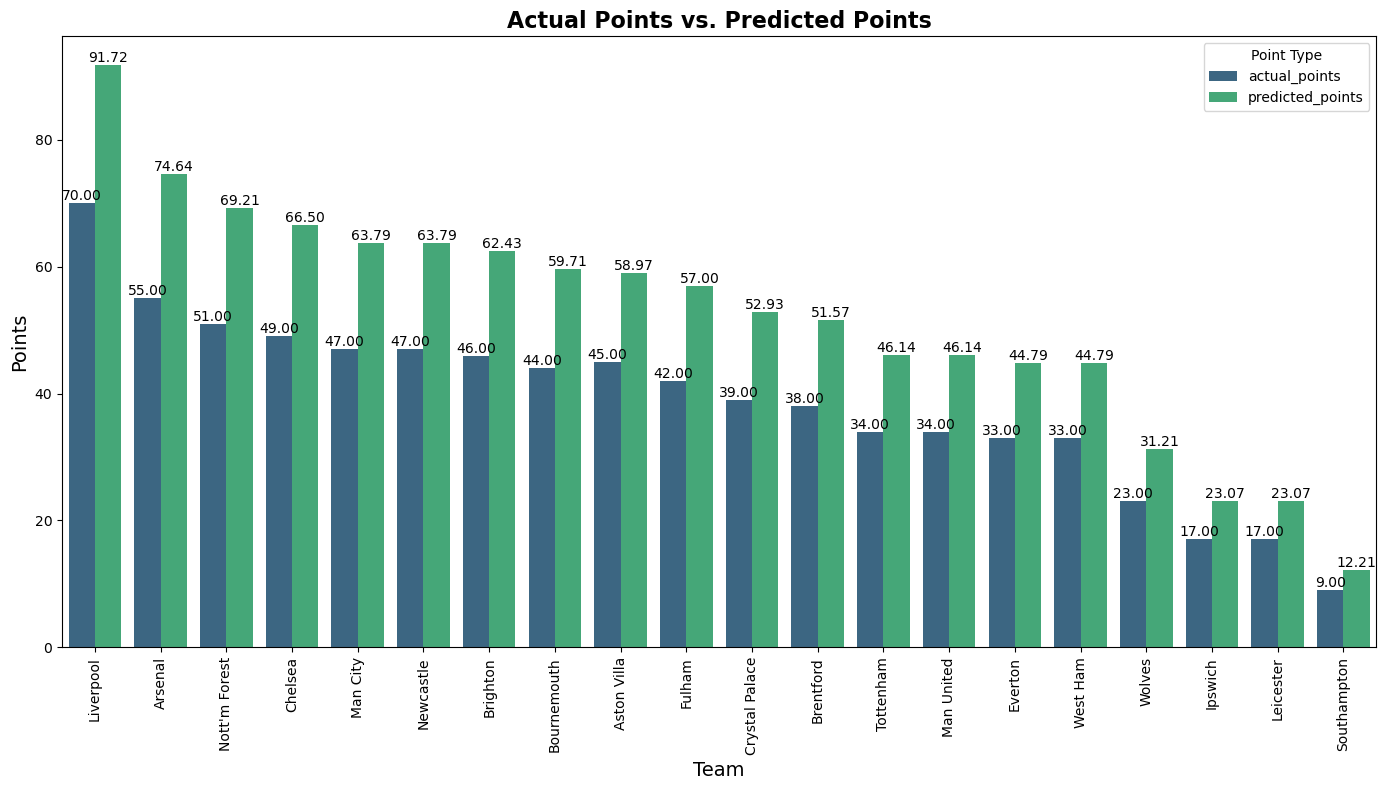

In [45]:
# Calculate actual points for each team
home_actual_points = df.groupby('home_team')['home_points'].sum()
away_actual_points = df.groupby('away_team')['away_points'].sum()
total_actual_points = home_actual_points.add(away_actual_points, fill_value=0)

# Add actual points to team_stats
team_stats['actual_points'] = team_stats['team'].map(total_actual_points)

# Fill missing values with 0 (if any)
team_stats['actual_points'].fillna(0, inplace=True)
team_stats['predicted_points'].fillna(0, inplace=True)

# Rename the existing 'points' column to avoid conflict
team_stats.rename(columns={'points': 'total_points'}, inplace=True)

# Prepare data for visualization
team_stats_melted = team_stats.melt(id_vars=['team'], value_vars=['actual_points', 'predicted_points'], 
                                    var_name='point_type', value_name='points')

# Visualize Actual Points vs. Predicted Points
plt.figure(figsize=(14, 8))
ax = sns.barplot(x='team', y='points', hue='point_type', data=team_stats_melted, palette='viridis')
plt.title('Actual Points vs. Predicted Points', fontsize=16, fontweight='bold')
plt.xlabel('Team', fontsize=14)
plt.ylabel('Points', fontsize=14)
plt.xticks(rotation=90)  # Rotate team names for better readability
plt.legend(title='Point Type', loc='upper right')

# Add annotations
for p in ax.patches:
    height = p.get_height()
    ax.annotate(
        f'{height:.2f}',  # Annotation text
        (p.get_x() + p.get_width() / 2, height),  # Position of annotation
        ha='center', va='bottom', fontsize=10, color='black'
    )

plt.tight_layout()  # Adjust layout to prevent overlapping
plt.show()

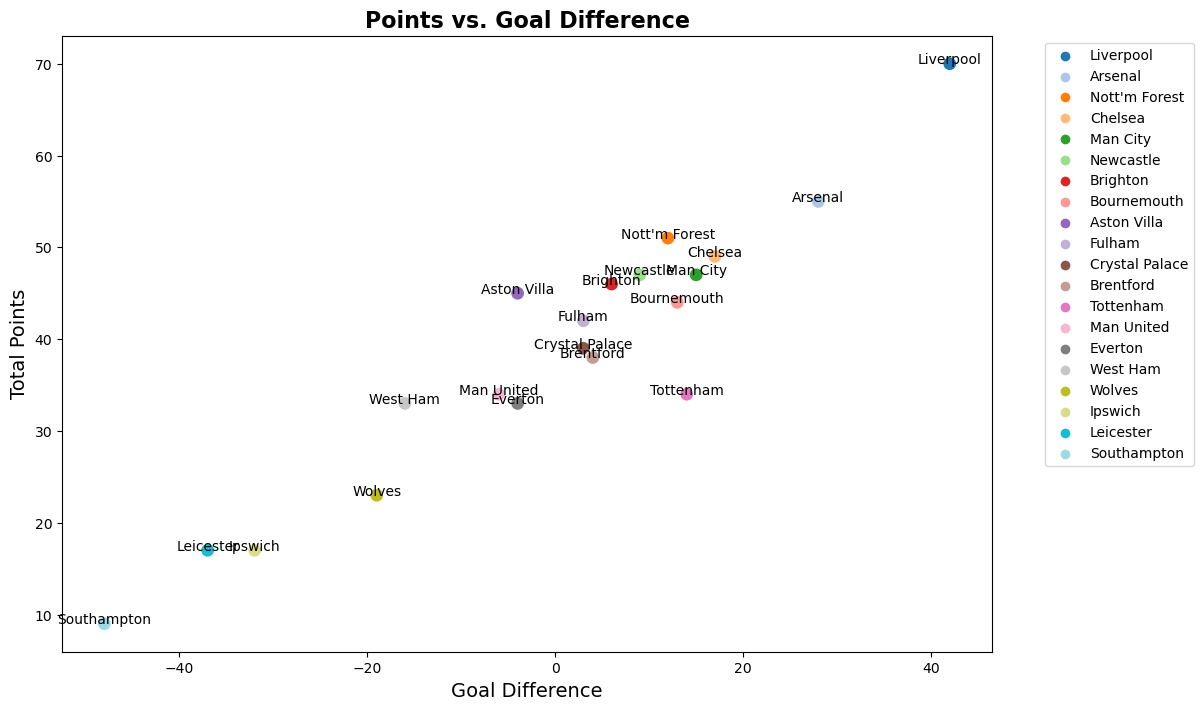

In [48]:
# Key Metrics Correlation
plt.figure(figsize=(12, 8))
sns.scatterplot(x='goal_difference', y='total_points', data=team_stats, hue='team', palette='tab20', s=100)
plt.title('Points vs. Goal Difference', fontsize=16, fontweight='bold')
plt.xlabel('Goal Difference', fontsize=14)
plt.ylabel('Total Points', fontsize=14)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
# Add team names as labels
for i, row in team_stats.iterrows():
    plt.text(row['goal_difference'], row['total_points'], row['team'], fontsize=10, ha='center')
plt.show()



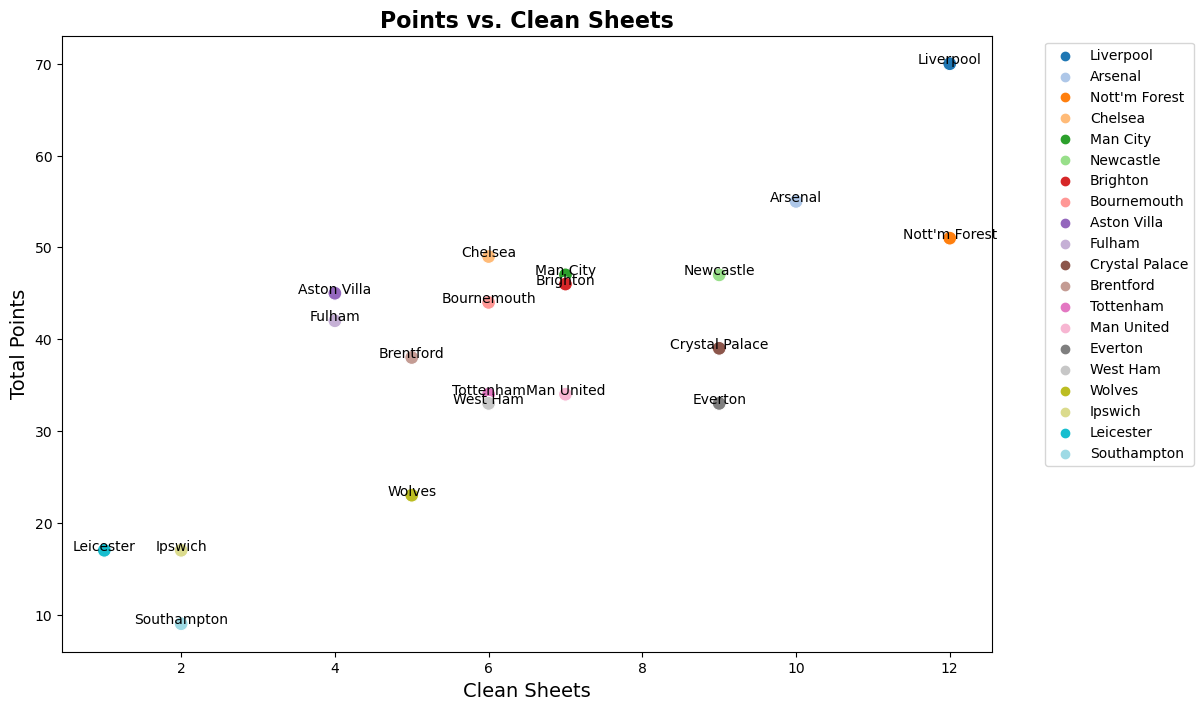

In [49]:
plt.figure(figsize=(12, 8))
sns.scatterplot(x='clean_sheets', y='total_points', data=team_stats, hue='team', palette='tab20', s=100)
plt.title('Points vs. Clean Sheets', fontsize=16, fontweight='bold')
plt.xlabel('Clean Sheets', fontsize=14)
plt.ylabel('Total Points', fontsize=14)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
# Add team names as labels
for i, row in team_stats.iterrows():
    plt.text(row['clean_sheets'], row['total_points'], row['team'], fontsize=10, ha='center')
plt.show()



Final Standings for the End of the Season:
              team  predicted_points
1        Liverpool         91.724138
2          Arsenal         74.642857
3    Nott'm Forest         69.214286
4          Chelsea         66.500000
5         Man City         63.785714
6        Newcastle         63.785714
7         Brighton         62.428571
8      Bournemouth         59.714286
9      Aston Villa         58.965517
10          Fulham         57.000000
11  Crystal Palace         52.928571
12       Brentford         51.571429
13       Tottenham         46.142857
14      Man United         46.142857
15         Everton         44.785714
16        West Ham         44.785714
17          Wolves         31.214286
18         Ipswich         23.071429
19       Leicester         23.071429
20     Southampton         12.214286


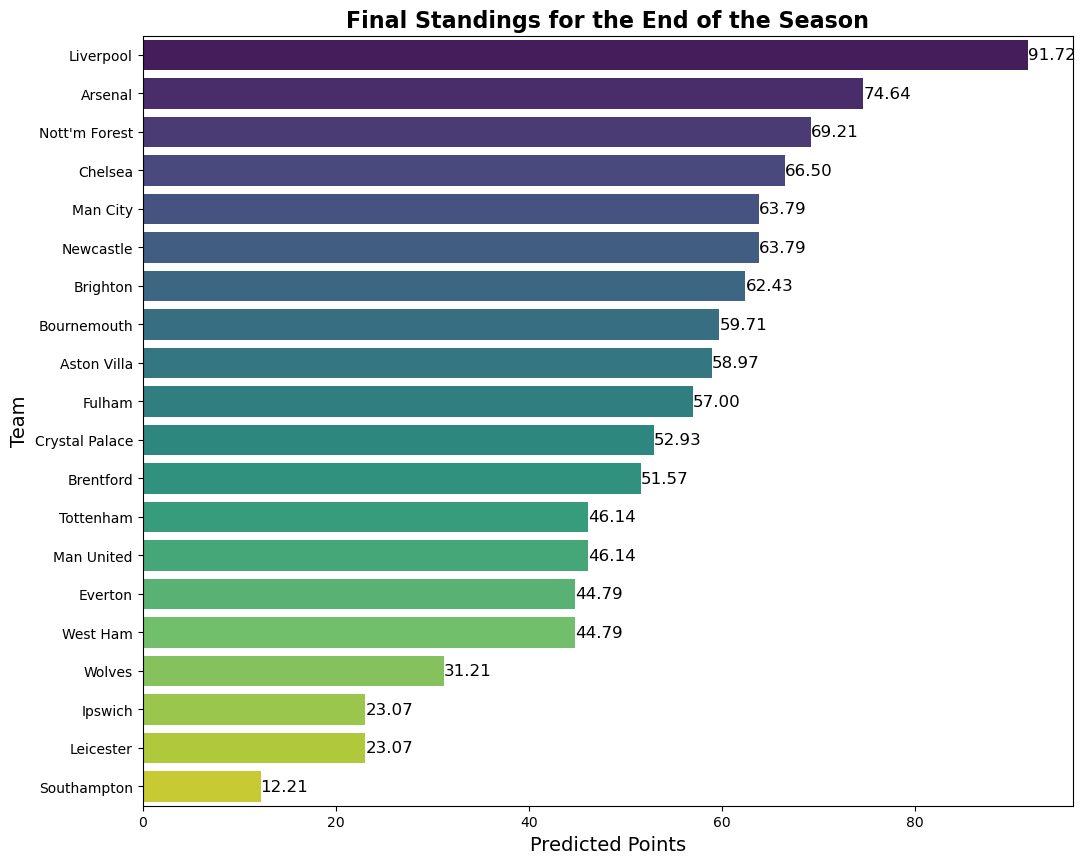

In [50]:
# Final Standings for the End of the Season
final_standings = team_stats[['team', 'predicted_points']].sort_values(by='predicted_points', ascending=False)

# Reset index for ranking
final_standings.reset_index(drop=True, inplace=True)
final_standings.index += 1  # Start ranking from 1 instead of 0

# Display Final Standings
print("Final Standings for the End of the Season:")
print(final_standings)

# Visualize Final Standings
plt.figure(figsize=(12, 10))
sns.barplot(x='predicted_points', y='team', data=final_standings, palette='viridis')
plt.title('Final Standings for the End of the Season', fontsize=16, fontweight='bold')
plt.xlabel('Predicted Points', fontsize=14)
plt.ylabel('Team', fontsize=14)
# Add annotations
for index, value in enumerate(final_standings['predicted_points']):
    plt.text(value, index, f'{value:.2f}', va='center', fontsize=12, color='black')
plt.show()

In [52]:
from sklearn.metrics import r2_score

# Predict on the test set
y_pred = model.predict(X_test)

# Calculate R² score
r2 = r2_score(y_test, y_pred)

# Express accuracy as a percentage
accuracy_percentage = r2 * 100

# Print the validation accuracy
print(f"Validation Accuracy (R²): {accuracy_percentage:.2f}%")

Validation Accuracy (R²): 98.72%
